In [1]:
import os
import shutil
from time import sleep
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np

from batchflow.models.tf import EfficientNetB0, EfficientNetB1, EfficientNetB2

from batchflow import Pipeline, B, V, C, D, ImagesBatch
from batchflow.opensets import CIFAR10
from batchflow.research import Option, Research, Results

%env CUDA_VISIBLE_DEVICES='6,7'

W0917 08:17:11.582078 139869369652992 deprecation_wrapper.py:119] From /notebooks/tonya/batchflow/batchflow/batchflow/models/tf/losses/dice.py:6: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0917 08:17:11.585247 139869369652992 deprecation_wrapper.py:119] From /notebooks/tonya/batchflow/batchflow/batchflow/models/tf/losses/dice.py:6: The name tf.losses.Reduction is deprecated. Please use tf.compat.v1.losses.Reduction instead.

W0917 08:17:11.587554 139869369652992 deprecation_wrapper.py:119] From /notebooks/tonya/batchflow/batchflow/batchflow/models/tf/base.py:22: The name tf.losses.mean_squared_error is deprecated. Please use tf.compat.v1.losses.mean_squared_error instead.

W0917 08:17:11.588288 139869369652992 deprecation_wrapper.py:119] From /notebooks/tonya/batchflow/batchflow/batchflow/models/tf/base.py:23: The name tf.losses.sigmoid_cross_entropy is deprecated. Please use tf.compat.v1.losses.sigmoid_cross_entropy instead.

W0917 08:17:11.58897

env: CUDA_VISIBLE_DEVICES='6,7'


In [2]:
cifar = CIFAR10(batch_class=ImagesBatch, bar=True)


100%|██████████| 6/6 [00:06<00:00,  1.33s/it]


In [3]:
# new_res = EfficientNetB0.resolution
# im_shape = (new_res, new_res, 3)

model_config = {
    'inputs/images/shape': B('image_shape'), #im_shape,
    'inputs/labels/classes': D('num_classes'),
    'initial_block/inputs': 'images',
    'loss': 'ce'
}

train_ppl = (cifar.train.p
#                   .resize((new_res, new_res))
                  .init_variable('loss_history', default=[])
                  .init_model('dynamic', EfficientNetB0, 'model', config=model_config)
                  .to_array()
                  .train_model('model', fetches='loss', images=B('images'), labels=B('labels'), 
                               save_to=V('loss_history', mode='a'))
                  .run_later(64, shuffle=True, n_epochs=3, drop_last=True))

In [4]:
train_ppl = train_ppl.run(bar=True)

  0%|          | 0/2343 [00:00<?, ?it/s]W0917 08:17:18.497344 139869369652992 deprecation_wrapper.py:119] From /notebooks/tonya/batchflow/batchflow/batchflow/models/tf/base.py:319: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0917 08:17:18.499537 139869369652992 deprecation_wrapper.py:119] From /notebooks/tonya/batchflow/batchflow/batchflow/models/tf/base.py:321: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0917 08:17:18.511238 139869369652992 deprecation_wrapper.py:119] From /notebooks/tonya/batchflow/batchflow/batchflow/models/tf/base.py:380: The name tf.get_variable_scope is deprecated. Please use tf.compat.v1.get_variable_scope instead.

W0917 08:17:18.518027 139869369652992 deprecation.py:323] From /notebooks/tonya/batchflow/batchflow/batchflow/models/tf/layers/conv.py:26: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions fo

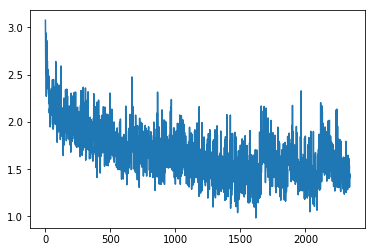

In [5]:
from matplotlib import pyplot as plt
plt.plot(train_ppl.get_variable('loss_history'))

In [6]:
test_pipeline = (cifar.test.p
                .import_model('model', train_ppl)
                .init_variable('predictions') 
                .init_variable('metrics') 
                .to_array()
                .predict_model('model', fetches='predictions', 
                               images=B('images'),
                               save_to=V('predictions'))
                .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                                fmt='logits', axis=-1, save_to=V('metrics', mode='u'))
                .run(64, shuffle=True, n_epochs=1, drop_last=False, bar=True)
)

100%|██████████| 157/157 [00:11<00:00, 17.19it/s]


In [7]:
metrics = test_pipeline.get_variable('metrics')

metrics.evaluate('accuracy')

0.5168

In [8]:
train_ppl = (cifar.train.p
                  .init_variable('loss_history', default=[])
                  .init_model('dynamic', EfficientNetB1, 'model', config=model_config)
                  .to_array()
                  .train_model('model', fetches='loss', images=B('images'), labels=B('labels'), 
                               save_to=V('loss_history', mode='a'))
                  .run_later(64, shuffle=True, n_epochs=3, drop_last=True))

In [9]:
train_ppl = train_ppl.run(bar=True)

100%|██████████| 2343/2343 [17:57<00:00,  2.17it/s]


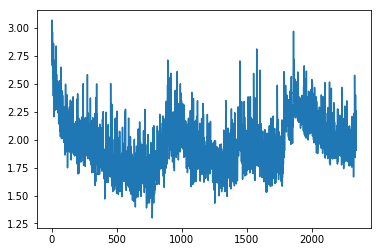

In [10]:
plt.plot(train_ppl.get_variable('loss_history'))

In [11]:
test_pipeline = (cifar.test.p
                .import_model('model', train_ppl)
                .init_variable('predictions') 
                .init_variable('metrics') 
                .to_array()
                .predict_model('model', fetches='predictions', 
                               images=B('images'),
                               save_to=V('predictions'))
                .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                                fmt='logits', axis=-1, save_to=V('metrics', mode='u'))
                .run(64, shuffle=True, n_epochs=1, drop_last=False, bar=True)
)

100%|██████████| 157/157 [00:14<00:00, 12.54it/s]


In [12]:
metrics = test_pipeline.get_variable('metrics')

metrics.evaluate('accuracy')

0.2575